# ProGAN

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import copy
import os

## Increasing Variation Using Minibatch Standard Deviation

In [2]:
class MinibatchStdDev(nn.Module):
    def __init__(self, in_channels, group_size=4, epsilon=1e-8):
        super().__init__()

        self.in_channels = in_channels
        self.group_size = group_size
        self.epsilon = epsilon
    
    def forward(self, x):
        assert self.group_size <= x.shape[0]

        B, C, H, W = x.shape

        y = x.view(self.group_size, -1, C, H, W)              # GMCHW
        y = y - y.mean(dim=0, keepdim=True)                   # GMCHW
        y = torch.sqrt(y.square().mean(dim=0) + self.epsilon) # MCHW
        y = y.mean(dim=[1, 2, 3], keepdim=True)               # M111
        y = y.repeat(self.group_size, 1, H, W)                # B1HW
        y = torch.cat([x, y], dim=1)                          # B(C+1)HW

        return y

MinibatchStdDev(10)(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 11, 4, 4])

## Equalized Learning Rate

$\^{w} = w_i \times \sqrt{\frac{2}{k \times k \times c}}$

$k \times k \times c = $ filters size

In [3]:
class EqualizedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(2/(kernel_size * kernel_size * in_channels))

    def forward(self, x):
        return torch.conv2d(x, self.weight * self.scale, self.bias, self.stride, self.padding)

EqualizedConv2d(10, 20, 3, 1, 0)(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 20, 2, 2])

In [4]:
class EqualizedConvTranspose2d(nn.ConvTranspose2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(2/(kernel_size * kernel_size * in_channels))

    def forward(self, x):
        return torch.conv_transpose2d(x, self.weight * self.scale, self.bias, self.stride, self.padding)

EqualizedConvTranspose2d(512, 512, 4, 1, 0)(torch.randn(4, 512, 1, 1)).shape

torch.Size([4, 512, 4, 4])

In [5]:
class EqualizedLinear(nn.Linear):
    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

        self.scale = np.sqrt(2/in_features)
    
    def forward(self, x):
        return F.linear(x, self.weight * self.scale, self.bias)

EqualizedLinear(20, 10)(torch.randn(32, 20)).shape

torch.Size([32, 10])

## Pixelwise Feature Vector Normalization In Generator

$b_{x, y} = a_{x, y} / \sqrt{\frac{1}{N} \sum^{N-1}_{j=0} (a_{x, y}^j)^2 + \epsilon}$

In [6]:
class PixelwiseFeatureVectorNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()

        self.epsilon = epsilon

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)


PixelwiseFeatureVectorNormalization()(torch.randn(32, 10, 4, 4)).shape

torch.Size([32, 10, 4, 4])

## Discriminator

<img src="discriminator.png" width="400"/>

In [7]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            EqualizedConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            EqualizedConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(2),
        )

    def forward(self, x):
        return self.net(x)


DiscriminatorBlock(in_channels=32, out_channels=64)(torch.randn(1, 32, 512, 512)).shape

torch.Size([1, 64, 256, 256])

In [8]:
class DiscriminatorFinalBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.net = nn.Sequential(
            MinibatchStdDev(in_channels=in_channels),
            EqualizedConv2d(in_channels+1, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            EqualizedConv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            EqualizedLinear(in_channels, 1)
        )
    
    def forward(self, x):
        return self.net(x).squeeze(1)


DiscriminatorFinalBlock(in_channels=512)(torch.randn(4, 512, 4, 4)).shape

torch.Size([4])

In [9]:
def is_power_of_two(num):
    return (num & (num - 1)) == 0 and num != 0

def get_num_of_steps_from_image_size(image_size):
    return int(np.log2(image_size) - 1)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, image_size=1024, image_channels=3, steps_in_channels=[16, 32, 64, 128, 256, 512, 512, 512, 512]):
        super().__init__()
        
        self.image_size = image_size
        
        assert is_power_of_two(image_size)
        self.num_steps = get_num_of_steps_from_image_size(image_size)

        assert len(steps_in_channels) == self.num_steps

        self.net = nn.ModuleList([
            DiscriminatorBlock(in_channels, out_channels) for in_channels, out_channels in zip(steps_in_channels[:-1], steps_in_channels[1:])
        ])
        self.net.append(DiscriminatorFinalBlock(steps_in_channels[-1]))

        self.from_rgb = nn.ModuleList([
            nn.Sequential(
                EqualizedConv2d(image_channels, in_channels, kernel_size=1, stride=1, padding=0),
                nn.LeakyReLU(negative_slope=0.2)
            ) for in_channels in steps_in_channels
        ])

        self.img_downsampler = nn.AvgPool2d(2)

    def forward(self, image, step: int, alpha: float):
        assert alpha >= 0 and alpha <= 1
        assert step >= 0 and step < self.num_steps

        first_layer_idx = self.num_steps - step - 1

        assert image.shape[2] == self.image_size>>first_layer_idx

        if step == 0:
            return self.net[-1](self.from_rgb[-1](image))

        first_layer_output = self.net[first_layer_idx](self.from_rgb[first_layer_idx](image))
        second_layer_from_rgb = self.from_rgb[first_layer_idx+1](self.img_downsampler(image))
        x = alpha * first_layer_output + (1 - alpha) * second_layer_from_rgb 
        for i in range(first_layer_idx+1, self.num_steps):
            x = self.net[i](x)
        
        return x

    
print(Discriminator()(image=torch.randn(4, 3, 4, 4), step=0, alpha=0).shape)
print(Discriminator()(image=torch.randn(4, 3, 16, 16), step=2, alpha=0).shape)
print(Discriminator()(image=torch.randn(4, 3, 256, 256), step=6, alpha=0).shape)
print(Discriminator()(image=torch.randn(4, 3, 1024, 1024), step=8, alpha=0).shape)
print("------------------")
print(Discriminator(image_size=256, steps_in_channels=[64, 128, 256, 512, 512, 512, 512])(image=torch.randn(4, 3, 256, 256), step=6, alpha=0).shape)

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
------------------
torch.Size([4])


## Generator

<img src="generator.png" width="400"/>

In [11]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.Upsample(scale_factor=2),
            EqualizedConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            PixelwiseFeatureVectorNormalization(),
            EqualizedConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            PixelwiseFeatureVectorNormalization(),
        )

    def forward(self, x):
        return self.net(x)


GeneratorBlock(in_channels=64, out_channels=32)(torch.randn(1, 64, 256, 256)).shape

torch.Size([1, 32, 512, 512])

In [12]:
class GeneratorInitialBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.net = nn.Sequential(
            PixelwiseFeatureVectorNormalization(),
            EqualizedConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.2),
            EqualizedConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            PixelwiseFeatureVectorNormalization()
        )
    
    def forward(self, x):
        return self.net(x)


GeneratorInitialBlock(512)(torch.randn(4, 512, 1, 1)).shape

torch.Size([4, 512, 4, 4])

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim=512, image_size=1024, image_channels=3, steps_out_channels=[512, 512, 512, 256, 128, 64, 32, 16]):
        super().__init__()
        
        assert is_power_of_two(image_size)
        self.num_steps = get_num_of_steps_from_image_size(image_size)

        assert len(steps_out_channels) == self.num_steps - 1

        self.net = nn.ModuleList([GeneratorInitialBlock(z_dim)])

        steps_in_channels = [z_dim] + steps_out_channels[:-1]
        for in_channels, out_channels in zip(steps_in_channels, steps_out_channels):
            self.net.append(GeneratorBlock(in_channels, out_channels))

        self.to_rgb = nn.ModuleList([
            EqualizedConv2d(channels, image_channels, kernel_size=1, stride=1, padding=0) for channels in [z_dim] + steps_out_channels
        ])

        self.img_upsampler = nn.Upsample(scale_factor=2)

    def forward(self, z, step: int, alpha: float):
        assert alpha >= 0 and alpha <= 1
        assert step >= 0 and step < self.num_steps

        if step == 0:
            return self.to_rgb[0](self.net[0](z))
        
        prev_step_output = z
        for i in range(step):
            prev_step_output = self.net[i](prev_step_output)
            
        prev_step_rgb = self.to_rgb[step-1](prev_step_output)
        prev_step_rgb_upsampled = self.img_upsampler(prev_step_rgb)
        
        step_output = self.net[step](prev_step_output)
        step_rgb = self.to_rgb[step](step_output)

        final_rgb = alpha * step_rgb + (1 - alpha) * prev_step_rgb_upsampled

        return final_rgb


print(Generator()(z=torch.randn(2, 512, 1, 1), step=0, alpha=0).shape)
print(Generator()(z=torch.randn(2, 512, 1, 1), step=1, alpha=0).shape)
print(Generator()(z=torch.randn(2, 512, 1, 1), step=5, alpha=0).shape)
print(Generator()(z=torch.randn(2, 512, 1, 1), step=6, alpha=0).shape)
print(Generator()(z=torch.randn(2, 512, 1, 1), step=8, alpha=0).shape)

torch.Size([2, 3, 4, 4])
torch.Size([2, 3, 8, 8])
torch.Size([2, 3, 128, 128])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 1024, 1024])


In [14]:
def update_exponential_moving_average_generator(ema_gen, gen, decay=0.999):
    gen_named_parameters = dict(gen.named_parameters())
    with torch.no_grad():
        for param_name, param in ema_gen.named_parameters():
            param.copy_(param * decay + (1. - decay) * gen_named_parameters[param_name])

## Training on CelebA-HQ $(128 \times 128)$

In [15]:
def show_images(images, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid((images + 1) / 2).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

In [16]:
def calc_gradient_penalty(critic, real_images, fake_images, step, alpha, device):
    eps = torch.rand((real_images.size(0), *(1 for _ in range(len(real_images.shape) - 1))), requires_grad=True).to(device)
    intermediate_images = eps * real_images + (1 - eps) * fake_images
    scores = critic(intermediate_images, step, alpha)
    gradients = torch.autograd.grad(outputs=scores, inputs=intermediate_images, grad_outputs=torch.ones_like(scores), create_graph=True, retain_graph=True)[0]
    gradients_norm = torch.norm(gradients.view(gradients.shape[0], -1), dim=1)
    gp = torch.mean((gradients_norm - 1) ** 2)
    
    return gp

In [17]:
class AdjustPixelsRange(object):
    def __init__(self, range_in, range_out):
        self._range_in = torch.tensor(range_in, dtype=torch.float32)
        self._range_out = torch.tensor(range_out, dtype=torch.float32)

        if range_in == range_out:
            self.scale = 1
            self.bias = 0
        else:
            self.scale = (self._range_out[1] - self._range_out[0]) / (self._range_in[1] - self._range_in[0])
            self.bias = self._range_out[0] - self.scale * self._range_in[0]
    
    def __call__(self, x):
        return torch.clamp(self.scale * x + self.bias, min=self._range_out[0], max=self._range_out[1])

a = np.random.uniform(10, 25, 5)
print(a)
print(AdjustPixelsRange((10, 20), (0, 1))(a).tolist())

[14.19002018 10.57909343 10.55492756 20.53313298 21.97825648]
[0.4190020387736071, 0.057909358703061464, 0.05549277191396218, 1.0, 1.0]


In [18]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    AdjustPixelsRange(range_in=(0., 1.), range_out=(-1., 1.))
])

dataset = torchvision.datasets.ImageFolder(root='../../data/celeba_hq', transform=transform)

In [2]:
plt.imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(dataset[1][0].permute(1, 2, 0)));

In [20]:
def generate_fixed_noise(size, seed):
    current_seed = torch.initial_seed()
    torch.manual_seed(seed)
    fixed_noise = torch.randn(size)
    torch.manual_seed(current_seed)
    
    return fixed_noise


print(torch.initial_seed())
fixed_noise1 = generate_fixed_noise((36, 100, 1, 1), seed=0)
fixed_noise2 = generate_fixed_noise((36, 100, 1, 1), seed=0)
fixed_noise3 = generate_fixed_noise((36, 100, 1, 1), seed=1)
print(torch.initial_seed())

torch.all(fixed_noise1 == fixed_noise2), torch.all(fixed_noise1 == fixed_noise3)

205177145924000
205177145924000


(tensor(True), tensor(False))

In [21]:
def generate_images_and_save(gen: Generator, step: int, epoch: int, alpha: float, fixed_noise: torch.Tensor, path: str):
    os.makedirs(path, exist_ok=True)

    with torch.no_grad():
        imgs = gen(fixed_noise, step, alpha).detach().cpu()
        imgs = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(imgs), nrow=6)
        imgs = transforms.Resize(1500)(imgs).permute(1, 2, 0).numpy()
    
    filename = f"Step {step} - Epoch {epoch} - Alpha {alpha:.2f}.png"
    
    plt.imsave(os.path.join(path, filename), imgs)

In [22]:
def process_batch_images(images, size: int, prev_size: int, alpha: float, current_size=256):
    assert is_power_of_two(size)
    assert prev_size is None or (is_power_of_two(prev_size) and prev_size == size >> 1)

    step_images = nn.AvgPool2d(current_size//size)(images)
    
    if prev_size is None:
        return step_images

    prev_step_images = nn.AvgPool2d(current_size//prev_size)(images)
    upsampled_prev_step_images = nn.Upsample(scale_factor=2)(prev_step_images)

    return alpha * step_images + (1 - alpha) * upsampled_prev_step_images


process_batch_images(torch.randn(16, 3, 256, 256), 8, 4, 0.7).shape

torch.Size([16, 3, 8, 8])

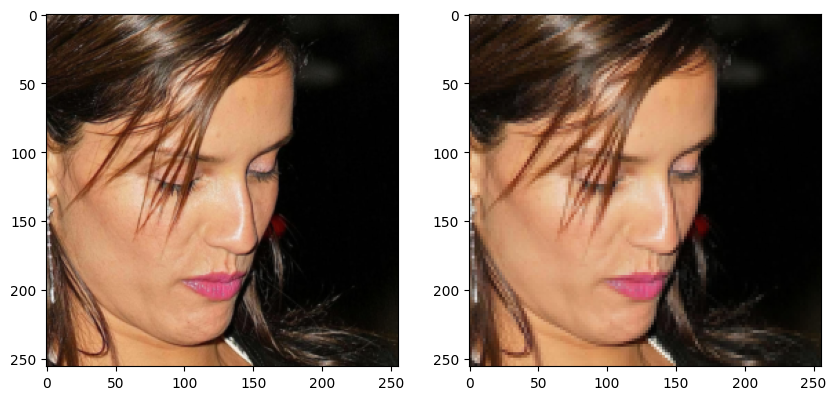

In [23]:
_, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(AdjustPixelsRange((-1, 1), (0, 1))(process_batch_images(dataset[0][0].unsqueeze(0), 256, 128, 1)[0].permute(1, 2, 0)));
axs[1].imshow(AdjustPixelsRange((-1, 1), (0, 1))(process_batch_images(dataset[0][0].unsqueeze(0), 256, 128, 0)[0].permute(1, 2, 0)));

In [24]:
def save_models_and_state(
    gen: Generator,
    ema_gen: Generator,
    crit: Discriminator,
    opt_gen: torch.optim.Adam,
    opt_crit: torch.optim.Adam,
    state: dict,
    path: str
):
    os.makedirs(path, exist_ok=True)
    
    torch.save(gen.state_dict(), os.path.join(path, 'gen.pth'))
    torch.save(ema_gen.state_dict(), os.path.join(path, 'ema_gen.pth'))
    torch.save(crit.state_dict(), os.path.join(path, 'crit.pth'))
    torch.save(opt_gen.state_dict(), os.path.join(path, 'opt_gen.pth'))
    torch.save(opt_crit.state_dict(), os.path.join(path, 'opt_crit.pth'))
    torch.save(state, os.path.join(path, 'state.pth'))

In [25]:
NOISE_DIM = 512
BATCH_SIZES = [16, 16, 16, 16, 16, 14, 14]
NUM_EPOCHS_PER_STEP = 50
NUM_CRITIC_UPDATE = 1
GP_LAMBDA = 10
DRIFT_LAMBDA = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [26]:
gen = Generator(z_dim=NOISE_DIM, image_size=256, image_channels=3, steps_out_channels=[512, 512, 512, 256, 128, 64]).to(device)
ema_gen = copy.deepcopy(gen)
crit = Discriminator(image_size=256, image_channels=3, steps_in_channels=[64, 128, 256, 512, 512, 512, 512]).to(device)

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0., 0.99), eps=1e-8)
opt_crit = torch.optim.Adam(crit.parameters(), lr=0.001, betas=(0., 0.99), eps=1e-8)

In [27]:
from_checkpoint = True

if from_checkpoint:
    gen.load_state_dict(torch.load('results_celebahq/step-5/gen.pth'))
    ema_gen.load_state_dict(torch.load('results_celebahq/step-5/ema_gen.pth'))
    crit.load_state_dict(torch.load('results_celebahq/step-5/crit.pth'))
    opt_gen.load_state_dict(torch.load('results_celebahq/step-5/opt_gen.pth'))
    opt_crit.load_state_dict(torch.load('results_celebahq/step-5/opt_crit.pth'))

    state = torch.load('results_celebahq/step-5/state.pth')
else:
    state = {}

    update_exponential_moving_average_generator(ema_gen, gen, decay=0) # I don't think it's needed

In [28]:
state

{'step': 5, 'alpha': 1, 'epoch': 49}

In [278]:
alpha_step = 1 / ((NUM_EPOCHS_PER_STEP // 2) * len(dataset))
step_image_sizes = [4, 8, 16, 32, 64, 128, 256]

In [29]:
import time

fixed_noise = generate_fixed_noise((36, NOISE_DIM, 1, 1), seed=123).to(device)
images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for step in range(state['step'] if from_checkpoint else 0, len(step_image_sizes)):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZES[step], shuffle=True)

    epoch_end = NUM_EPOCHS_PER_STEP if step != 0 else NUM_EPOCHS_PER_STEP//2

    if from_checkpoint and step == state['step']:
        alpha = state['alpha']
        range_epoch = range(state['epoch']+1, epoch_end)
        print(f"Continue from checkpoint: Step {step} - Epoch {state['epoch']+1} - Alpha {alpha:.4f}")
    else:
        alpha = 0
        range_epoch = range(epoch_end)

    for epoch in range_epoch:
        epoch_start_time = time.time()
        
        for real_images, _ in dataloader:
            real_images = process_batch_images(
                real_images,
                size=step_image_sizes[step],
                prev_size=None if step == 0 else step_image_sizes[step-1],
                alpha=alpha
            ).to(device)

            #----- Updating the Discriminator -----#
            for _ in range(NUM_CRITIC_UPDATE):
                noise = torch.randn(real_images.shape[0], NOISE_DIM, 1, 1).to(device)
                fake_images = gen(noise, step, alpha).detach()
                pred_real, pred_fake = crit(real_images, step, alpha), crit(fake_images, step, alpha)
                loss = -torch.mean(pred_real) + torch.mean(pred_fake) + GP_LAMBDA*calc_gradient_penalty(crit, real_images, fake_images, step, alpha, device)
                loss += DRIFT_LAMBDA * torch.mean(pred_real ** 2)
                crit.zero_grad()
                loss.backward(retain_graph=True)
                opt_crit.step()

            update_exponential_moving_average_generator(ema_gen, gen)

            #----- Updating the Generator -----#
            noise = torch.randn(BATCH_SIZES[step], NOISE_DIM, 1, 1).to(device)
            loss = -torch.mean(crit(gen(noise, step, alpha), step, alpha))
            gen.zero_grad()
            loss.backward()
            opt_gen.step()

            alpha = min(1, alpha + alpha_step * real_images.size(0))

        clear_output()
        print(f"Step {step} - Alpha {alpha:.2f} - Epoch {epoch} [Epoch time: {time.time() - epoch_start_time}]")
        generate_images_and_save(gen, step, epoch, alpha, fixed_noise, "new/results_celebahq/gen_images")
        generate_images_and_save(ema_gen, step, epoch, alpha, fixed_noise, "new/results_celebahq/ema_gen_images")

        save_models_and_state(gen, ema_gen, crit, opt_gen, opt_crit, {"step": step, "alpha": alpha, "epoch": epoch}, 'new/results_celebahq/')
        if epoch == range_epoch[-1]: # Step completed
            save_models_and_state(gen, ema_gen, crit, opt_gen, opt_crit, {"step": step, "alpha": alpha, "epoch": epoch}, f'new/results_celebahq/step-{step}/')

In [35]:
import cv2
import glob
import re
import moviepy.editor

def avi_to_gif(input_file, output_file):
    video = moviepy.editor.VideoFileClip(input_file)
    video.write_gif(output_file)

for video_name, folder_name in zip(['gen_training_procedure', 'ema_gen_training_procedure'], ['gen_images', 'ema_gen_images']):
    files = glob.glob(f'results_celebahq/{folder_name}/*.png')
    files_dict = []
    for f in files:
        m = re.search(r"Step (\d+) - Epoch (\d+)", f)
        if m is None:
            raise Exception("Something is wrong")
        files_dict.append({
            "step": int(m.group(1)),
            "epoch": int(m.group(2)),
            "filename": f
        })

    sorted_files_dict = sorted(files_dict, key=lambda x: (x['step'], x['epoch']))

    video = cv2.VideoWriter(f'{video_name}.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, (1500, 1500))

    for idx, file in enumerate(sorted_files_dict):
        img = cv2.imread(file['filename'])
        video.write(img)
        if idx == len(files) - 1:
            for _ in range(10 * 5):
                video.write(img)
    video.release()
    cv2.destroyAllWindows()

    avi_to_gif(f'{video_name}.avi', f'{video_name}.gif')

MoviePy - Building file gen_training_procedure.gif with imageio.


MoviePy - Building file ema_gen_training_procedure.gif with imageio.


<img src="gen_training_procedure.gif" width=500>
<img src="ema_gen_training_procedure.gif" width=500>

## Interpolation

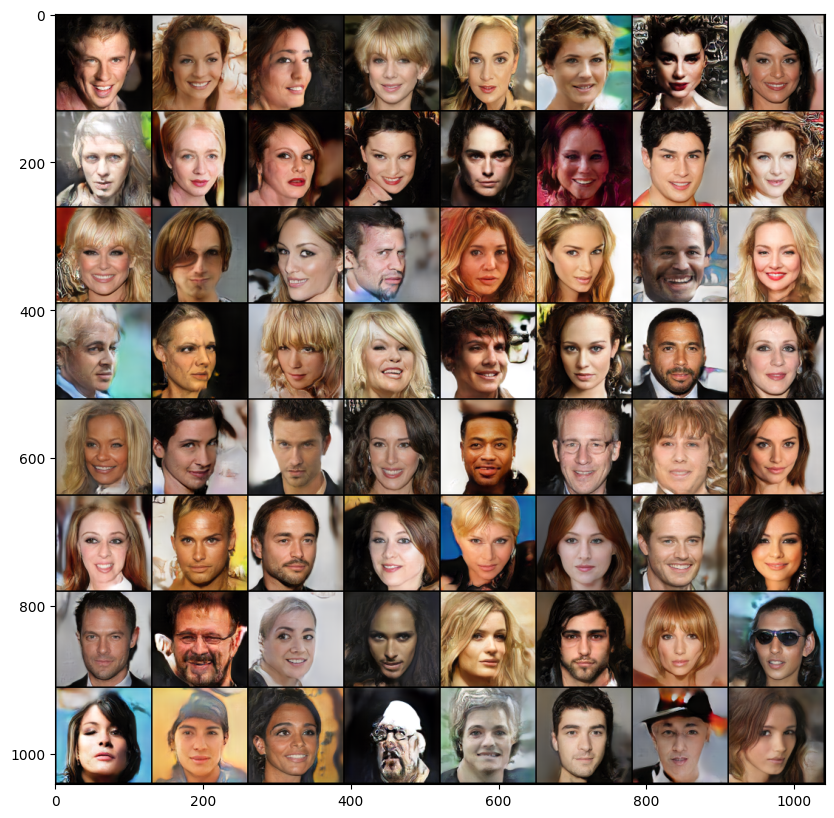

In [29]:
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1).to(device)
step = 5
alpha = 1

imgs = ema_gen(fixed_noise, step, alpha).detach().cpu()
img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(imgs), nrow=8).permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(img);

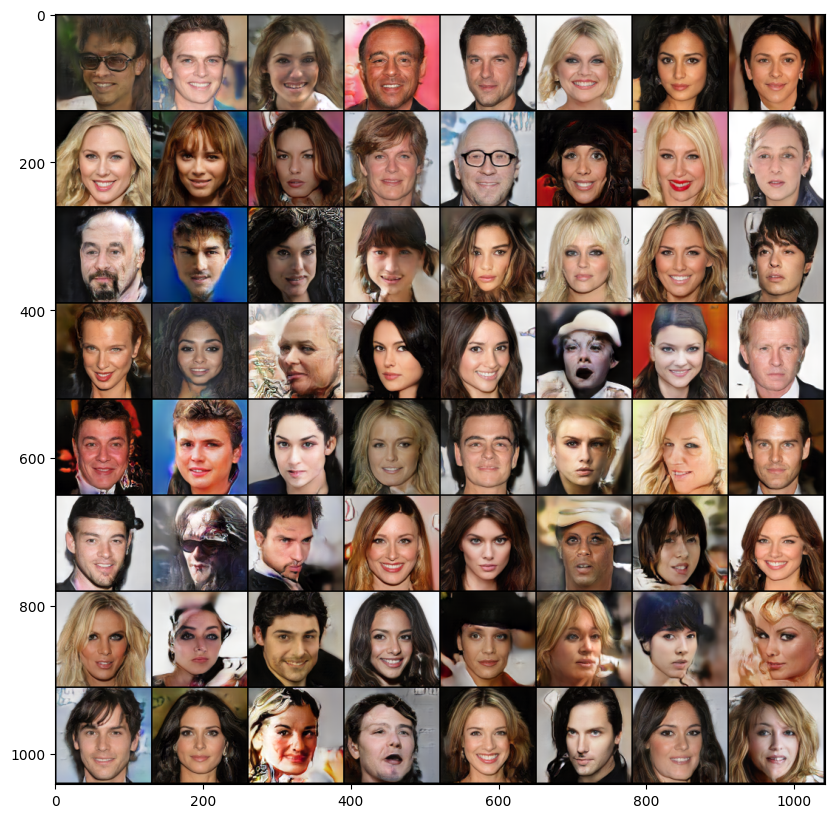

In [184]:
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1).to(device)
step = 5
alpha = 1

imgs = ema_gen(fixed_noise, step, alpha).detach().cpu()
img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(imgs), nrow=8).permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(img);

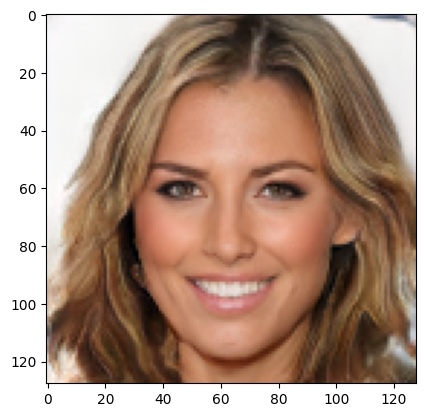

In [218]:
plt.imshow(AdjustPixelsRange((-1., 1.), (0., 1.))(imgs[22]).permute(1, 2, 0));

22


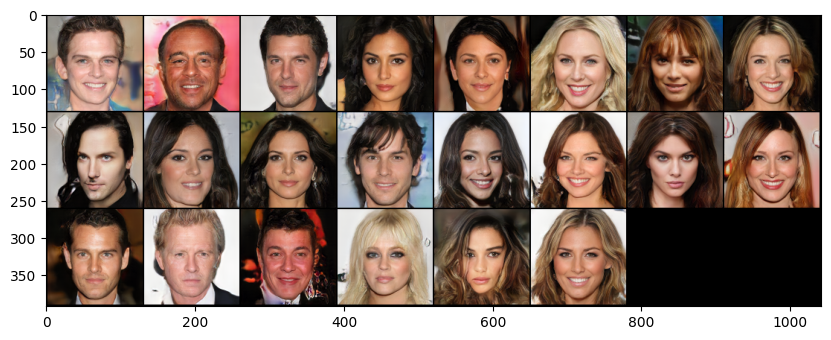

In [220]:
selected_indices = [1, 3, 4, 6, 7, 8, 9, 60, 61, 62, 57, 56, 51, 47, 44, 43, 39, 31, 32, 21, 20, 22]
print(len(selected_indices))

selected_noises = fixed_noise[selected_indices]
img = torchvision.utils.make_grid(AdjustPixelsRange((-1., 1.), (0., 1.))(imgs[selected_indices]), nrow=8).permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(img);

In [221]:
result = []
cnt = 20
percentage = torch.linspace(0, 1, cnt).view(cnt, 1, 1, 1).to(selected_noises[0].device)
for i in range(len(selected_noises)):
    j = i+1 if i < len(selected_noises)-1 else 0
    intermediate_noises = (selected_noises[i] * (1 - percentage)) + (selected_noises[j] * percentage)
    intermediate_images = ema_gen(intermediate_noises, step=step, alpha=alpha).detach().cpu().permute(0, 2, 3, 1)
    result.extend([*intermediate_images])

In [222]:
import cv2

video = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (128, 128))
ff = lambda x: (((x + 1) / 2).clip(0, 1) * 255).numpy().astype(np.uint8)
for img in result:
    video.write(cv2.cvtColor(ff(img), cv2.COLOR_BGR2RGB))
video.release()
cv2.destroyAllWindows()

In [223]:
import moviepy.editor

def avi_to_gif(input_file, output_file):
    video = moviepy.editor.VideoFileClip(input_file)
    video.write_gif(output_file)

avi_to_gif("output.avi", "output.gif")

MoviePy - Building file output.gif with imageio.


<img src="output.gif" width=300>
<img src="output2.gif" width=300>
<img src="output3.gif" width=250>